In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial import ConvexHull
import scanpy.external as sce
import scanpy as sc
import anndata as an
import scipy

from importlib import reload

# locals
import utils as ut
import plotting as plt2

In [2]:
sc.settings.verbosity = 4

# Load HSC Data

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.var_names = adata.var['gene_name'].values
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# include QC Data

In [4]:
fpath = "../resources/qc_barcodes.csv"
codes = pd.read_csv(fpath)
codes['OG_cluster'] = codes['cluster_str']

# Column to exclude from suffixing
exclude_column = 'cell_id'

# Suffix to add
suffix = '_QC'

# Create new column names with suffixes
new_columns = [col + suffix if col != exclude_column else col for col in codes.columns]

# Rename columns in the DataFrame
codes.columns = new_columns

print(f"{adata.obs.shape=} {codes.shape=}")


index = adata.obs_names.copy()

adata.obs = pd.merge(
    adata.obs, 
    codes,
    how='left',
    left_on='cell_id',
    right_on='cell_id',
)

adata.obs['OG_cluster_QC'] = adata.obs['OG_cluster_QC'].fillna('HSC')
adata.obs =  adata.obs.set_index(index)

adata.obs.head()

adata.obs.shape=(8563, 14) codes.shape=(8563, 11)


,cell_id,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,EC_score,EB_score,...,predicted_doublet_QC,cluster_str_QC,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,AAACCCAAGGTTACCT,2352,0.159948,False,2352,6558,0,0.0,-0.117695,1.107518,...,False,C1,False,True,True,True,False,True,False,C1
AAACCCAAGTTGAAGT,AAACCCAAGTTGAAGT,2324,0.046595,False,2324,5488,0,0.0,-1.490416,-0.212043,...,False,C1,False,False,False,False,False,False,False,C1
AAACCCAAGTTGTCGT,AAACCCAAGTTGTCGT,1676,0.056037,False,1676,4330,0,0.0,0.662667,-0.494800,...,False,C4,False,False,True,False,False,False,False,C4
AAACCCACAGAAGCGT,AAACCCACAGAAGCGT,1601,0.027108,False,1600,3442,0,0.0,-0.356942,2.013557,...,False,C2,False,True,False,True,False,False,False,C2
AAACCCACAGGAGGTT,AAACCCACAGGAGGTT,3604,0.118063,False,3604,14427,0,0.0,0.334405,-0.505029,...,False,C1,False,True,True,False,False,False,False,C1


# Load BJ Fib Data

In [5]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.h5ad"

bjdata = sc.read_h5ad(fpath)
bjdata = bjdata[bjdata.obs['dataset'] == 'chen_2015', :].copy()
bjdata.layers['raw_counts'] = bjdata.X.copy()
bjdata

AnnData object with n_obs × n_vars = 18 × 19393
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id'
    layers: 'raw_counts'

# Renormalize

In [6]:
def renormalize(adata):
    """Renormalizes an AnnData object by:

    1. Copying the existing 'X' matrix to a new layer called 'combat'.
    2. Replacing 'X' with the raw counts from 'raw_counts'.
    3. Filtering out genes expressed in only a single cell.
    4. Creating a new layer 'sqrt_norm' containing the square root of normalized counts.

    Args:
        adata: The AnnData object to renormalize.

    Returns:
       
       The renormalized AnnData object.
    """
    adata.X = adata.layers['raw_counts'].copy()
    adata.layers["sqrt_norm"] = np.sqrt(
        sc.pp.normalize_total(adata, inplace=False)["X"]
    )
    return adata


bjdata = renormalize(bjdata)
adata = renormalize(adata)

adata

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:01)


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'cell_id', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'predicted_doublet_QC', 'cluster_str_QC', 'candidate_QC', 'CD34_QC', 'GATA2_QC', 'GFI1B_QC', 'FOS_QC', 'STAT5A_QC', 'REL_QC', 'OG_cluster_QC'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tag

In [7]:
bjdata

AnnData object with n_obs × n_vars = 18 × 19393
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'n_counts', 'control'
    var: 'gene_id', 'token_id', 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_version', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'transcript_support_level', 'ensembl_id'
    layers: 'raw_counts', 'sqrt_norm'

# Join

In [8]:
# construct metadata columns
adata.obs['dataset'] = 'iHSC'
adata.obs['hour'] = 0.0

bjdata.obs['cell_id'] = bjdata.obs['sample_id']
bjdata.obs['candidate_QC'] = False
bjdata.obs['OG_cluster_QC'] = 'BJ'

bjdata.var['gene_name'] = bjdata.var.index.copy()




# rejoin the normalized counts
hdf = an.concat(
    [bjdata, adata],
    fill_value=0.0,
    join='inner', # switch to "outer" if we want genes not expressed in both datasets
)

hdf.uns = adata.uns.copy()

hdf.layers['combat'] = sc.pp.combat(hdf, key='dataset', inplace=False)
sc.pp.regress_out(hdf, keys='dataset')

sc.pp.filter_genes(hdf, min_cells=20) # at least a few cells in our dataset + all timepoints from bulk 

hdf

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data

regressing out dataset
    ... regressing on per-gene means within categories
    finished (0:02:57)
filtered out 1293 genes that are detected in less than 20 cells


AnnData object with n_obs × n_vars = 8581 × 13772
    obs: 'dataset', 'hour', 'cell_id', 'candidate_QC', 'OG_cluster_QC'
    var: 'n_cells'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    layers: 'raw_counts', 'sqrt_norm', 'combat'

# Some joint embeddings

In [9]:
# # PCA Analysis
# print("Performing PCA dimensionality reduction...")
# sc.pp.pca(
#     hdf, 
#     n_comps=50, 
#     mask_var=None
# )

# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['figure.figsize'] = 5, 3
# sc.pl.pca_variance_ratio(
#     hdf, 
# )

# plots

edf.shape=(8581, 25)


Text(0.5, 0, 'Expression')

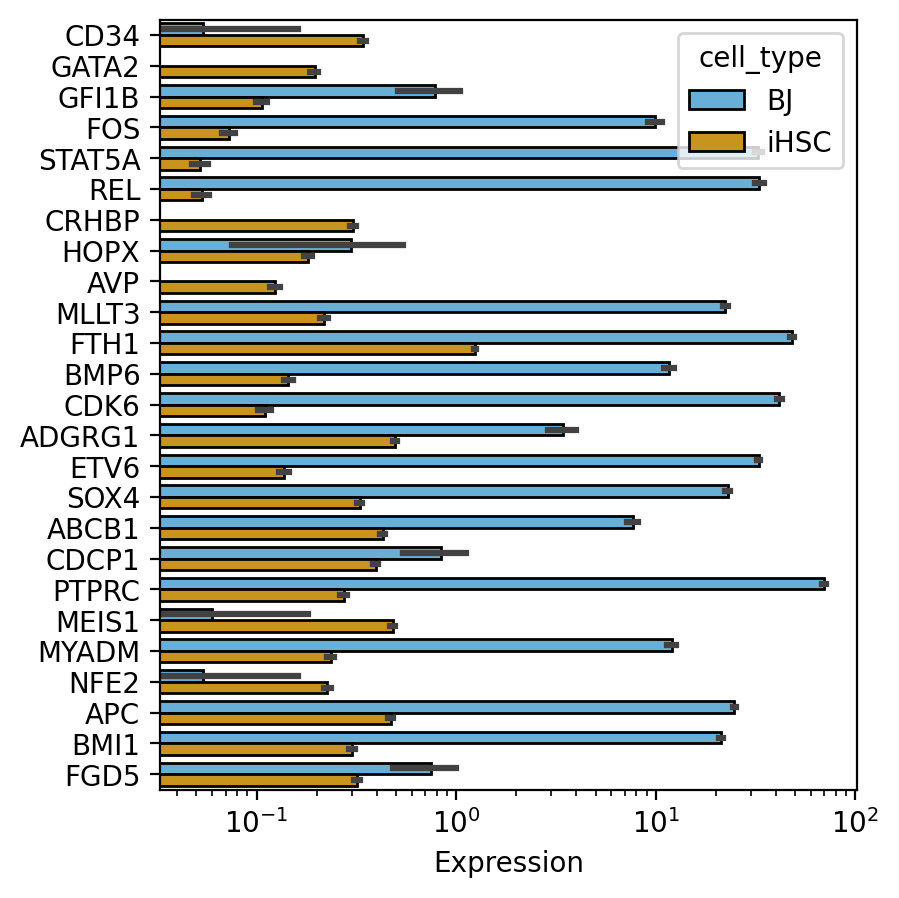

In [10]:

gene_list = [
    'CD34', 'GATA2', 'GFI1B',  'FOS', 'STAT5A', 'REL',
    'CRHBP', 'HOPX', 'AVP', 'MLLT3',
    'FTH1', 'BMP6',  'CDK6', 'ADGRG1', 'ETV6', 'SOX4',
    'ABCB1', 'CDCP1', 'PTPRC', 'MEIS1', 'MYADM', 'NFE2', 'APC', 'BMI1', 'FGD5',
    # 'MED12L', # 'RPS18', 'RPS4X', 'RPL10', 'RBPMS', 'HLF', 'MECOM', 'FLT3',
]
gene_list = [x for x in gene_list if x in hdf.var.index]

edf = hdf[:, gene_list].to_df(layer='sqrt_norm')

edf = ut.drop_zero_sum_columns(edf)
print(f"{edf.shape=}")

edf = edf.reset_index(names='cell_id')
edf = pd.melt(edf, id_vars='cell_id')
edf['cell_type'] = np.where(edf['cell_id'].str.contains('S'), 'BJ', 'iHSC')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.5, 5

sns.barplot(
    data=edf, 
    y='variable',
    x='value',
    ec='k',
    width=0.75,
    hue='cell_type',
    palette=["#56B4E9", "#E69F00"],
    # legend=False,
)

plt.xscale('log')
plt.ylabel("")
plt.xlabel("Expression")

In [11]:
edf.tail()

,cell_id,variable,value,cell_type
214520,TTTGTTGCAAGAGGTC,FGD5,0.0,iHSC
214521,TTTGTTGCATGTGGTT,FGD5,0.0,iHSC
214522,TTTGTTGGTATACCCA,FGD5,0.0,iHSC
214523,TTTGTTGTCACGTAGT,FGD5,0.0,iHSC
214524,TTTGTTGTCGATGCTA,FGD5,0.0,iHSC


In [12]:
hdf.var.head()

,n_cells
A1BG,679
A2M,43
A2ML1,3236
A3GALT2,1152
A4GNT,53
